In [1]:
import os
from glob import glob
from tqdm import tqdm

import cv2
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline
plt.ion()   # interactive mode

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.autograd import Variable
import torchvision
from torchvision import transforms, models
from torch.utils.data import DataLoader, Dataset

# sklearn libraries
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

In [2]:
import os
from glob import glob

# Define the base directory with the correct path structure
base_dir = '/kaggle/input/skin-cancer-mnist-ham10000'
image_paths_part1 = glob(os.path.join(base_dir, 'HAM10000_images_part_1', '*.jpg'))
image_paths_part2 = glob(os.path.join(base_dir, 'HAM10000_images_part_2', '*.jpg'))

# Combine the paths from both folders
all_image_path = image_paths_part1 + image_paths_part2

# Check if images are loaded correctly
if len(all_image_path) == 0:
    print("No images found. Please check the directory structure and file types.")
else:
    print(f"Found {len(all_image_path)} images in total.")

# Create a dictionary mapping image IDs to their full paths
imageid_path_dict = {os.path.splitext(os.path.basename(x))[0]: x for x in all_image_path}

# Print some sample entries to verify
print("Sample image paths:", list(imageid_path_dict.items())[:5])


Found 10015 images in total.
Sample image paths: [('ISIC_0028933', '/kaggle/input/skin-cancer-mnist-ham10000/HAM10000_images_part_1/ISIC_0028933.jpg'), ('ISIC_0028394', '/kaggle/input/skin-cancer-mnist-ham10000/HAM10000_images_part_1/ISIC_0028394.jpg'), ('ISIC_0027799', '/kaggle/input/skin-cancer-mnist-ham10000/HAM10000_images_part_1/ISIC_0027799.jpg'), ('ISIC_0028100', '/kaggle/input/skin-cancer-mnist-ham10000/HAM10000_images_part_1/ISIC_0028100.jpg'), ('ISIC_0027960', '/kaggle/input/skin-cancer-mnist-ham10000/HAM10000_images_part_1/ISIC_0027960.jpg')]


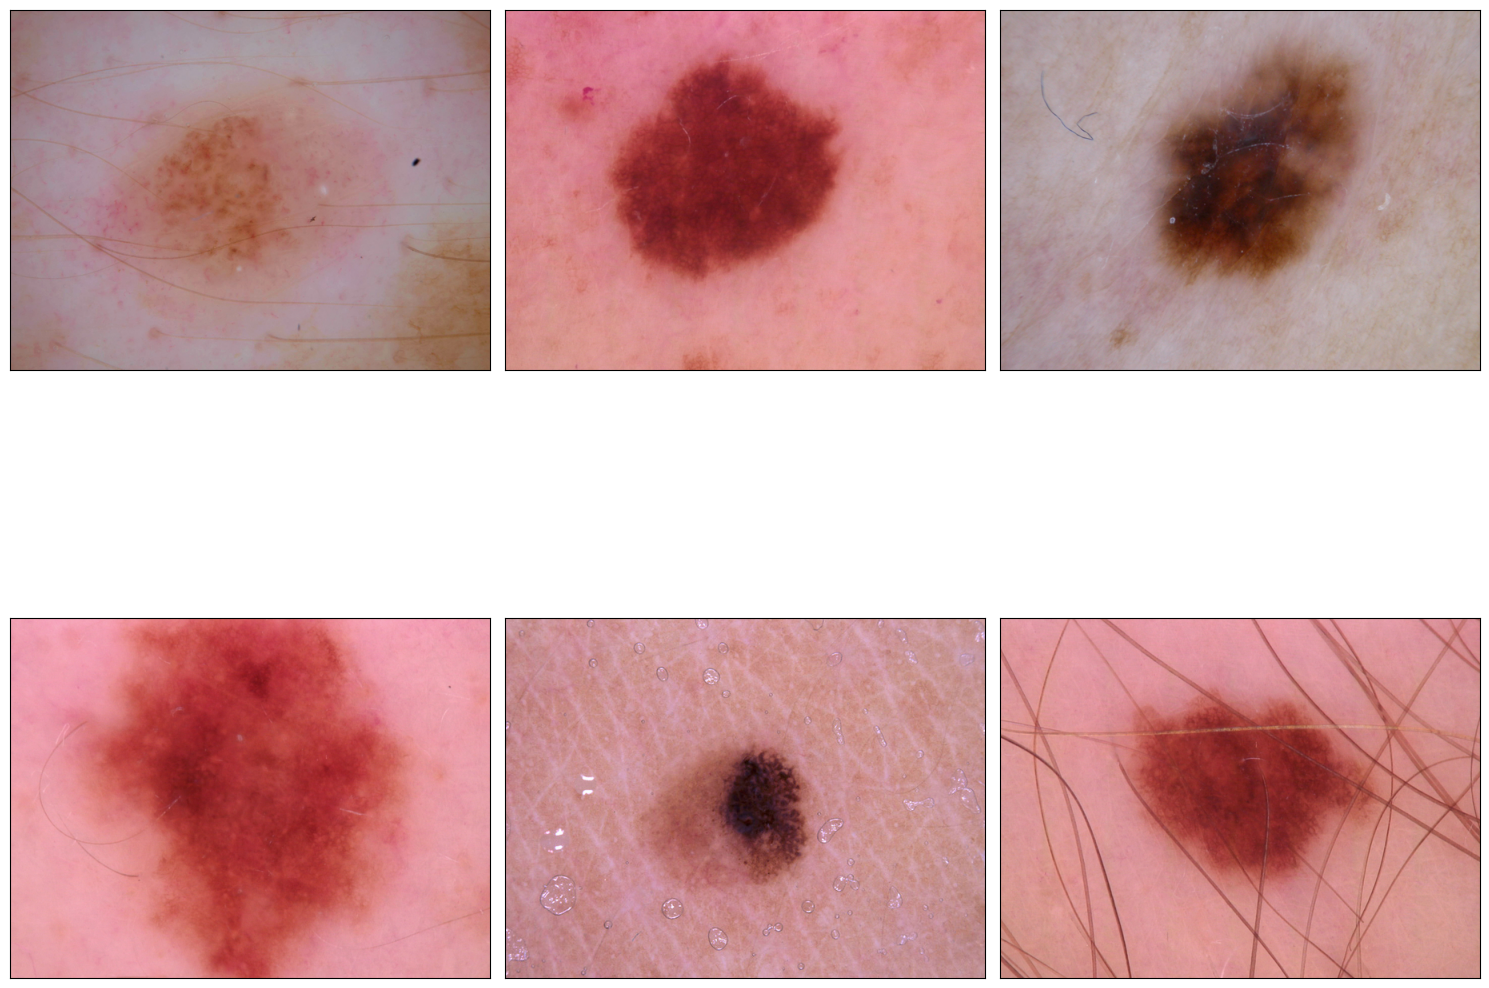

In [3]:
import random
import matplotlib.image as mpimg
import matplotlib.pyplot as plt

# Verify that all_image_path contains images
if len(all_image_path) == 0:
    print("No images found in the path. Please check the directory.")
else:
    # Parameters for the grid of images to display
    w, h = 10, 10
    fig = plt.figure(figsize=(15, 15))
    columns, rows = 3, 2
    
    # Set the range for random indices
    start, end = 0, len(all_image_path) - 1
    
    # List to store subplot axes
    ax = []
    
    for i in range(columns * rows):
        # Get a random index within the correct range
        k = random.randint(start, end)
        
        # Load the image at the randomly selected path
        img = mpimg.imread(all_image_path[k])
        
        # Create subplot and add it to the figure
        ax.append(fig.add_subplot(rows, columns, i + 1))
        
        # Hide x and y ticks for a cleaner look
        plt.xticks([])
        plt.yticks([])
        
        # Display the image
        plt.imshow(img, cmap="gray")

    plt.tight_layout()
    plt.show()  # Render the plot



In [4]:
# Checking the size and number of channels in the image
arr = np.asarray(Image.open(all_image_path[48]))
arr.shape

(450, 600, 3)

In [5]:
def compute_img_mean_std(image_paths):
    """
        computing the mean and std of three channel on the whole dataset,
        first we should normalize the image from 0-255 to 0-1
    """

    img_h, img_w = 224, 224
    imgs = []
    means, stdevs = [], []

    for i in tqdm(range(len(image_paths))):
        img = cv2.imread(image_paths[i])
        img = cv2.resize(img, (img_h, img_w))
        imgs.append(img)

    imgs = np.stack(imgs, axis=3)
    print(imgs.shape)

    imgs = imgs.astype(np.float32) / 255.

    for i in range(3):
        pixels = imgs[:, :, i, :].ravel()  # resize to one row
        means.append(np.mean(pixels))
        stdevs.append(np.std(pixels))

    means.reverse()  # BGR --> RGB
    stdevs.reverse()

    print("normMean = {}".format(means))
    print("normStd = {}".format(stdevs))
    return means,stdevs

In [6]:
normMean = [0.7630358, 0.54564357, 0.5700475]
normStd = [0.14092763, 0.15261263, 0.16997081]
# for future reference

In [7]:
lesion_type_dict = {
    'nv': 'Melanocytic nevi',
    'mel': 'Dermatofibroma',
    'bkl': 'Benign keratosis-like lesions',
    'bcc': 'Basal cell carcinoma',
    'akiec': 'Actinic keratoses',
    'vasc': 'Vascular lesions',
    'df': 'Dermatofibroma'
}


In [8]:
df_original = pd.read_csv(os.path.join(base_dir, 'HAM10000_metadata.csv'))
df_original['path'] = df_original['image_id'].map(imageid_path_dict.get)
df_original['cell_type'] = df_original['dx'].map(lesion_type_dict.get)
df_original['cell_type_idx'] = pd.Categorical(df_original['cell_type']).codes
df_original.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,path,cell_type,cell_type_idx
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,/kaggle/input/skin-cancer-mnist-ham10000/HAM10...,Benign keratosis-like lesions,2
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,/kaggle/input/skin-cancer-mnist-ham10000/HAM10...,Benign keratosis-like lesions,2
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,/kaggle/input/skin-cancer-mnist-ham10000/HAM10...,Benign keratosis-like lesions,2
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,/kaggle/input/skin-cancer-mnist-ham10000/HAM10...,Benign keratosis-like lesions,2
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,/kaggle/input/skin-cancer-mnist-ham10000/HAM10...,Benign keratosis-like lesions,2


In [9]:
df_original[['cell_type_idx', 'cell_type']].sort_values('cell_type_idx').drop_duplicates()

,cell_type_idx,cell_type
9803,0,Actinic keratoses
2909,1,Basal cell carcinoma
1017,2,Benign keratosis-like lesions
2198,3,Dermatofibroma
7509,4,Melanocytic nevi
2368,5,Vascular lesions


In [10]:
df_original['cell_type'].value_counts()

cell_type
Melanocytic nevi                 6705
Dermatofibroma                   1228
Benign keratosis-like lesions    1099
Basal cell carcinoma              514
Actinic keratoses                 327
Vascular lesions                  142
Name: count, dtype: int64

In [11]:
def compute_img_mean_std(image_paths):
    """
        computing the mean and std of three channel on the whole dataset,
        first we should normalize the image from 0-255 to 0-1
    """

    img_h, img_w = 224, 224
    imgs = []
    means, stdevs = [], []

    for i in tqdm(range(len(image_paths))):
        img = cv2.imread(image_paths[i])
        img = cv2.resize(img, (img_h, img_w))
        imgs.append(img)

    imgs = np.stack(imgs, axis=3)
    print(imgs.shape)

    imgs = imgs.astype(np.float32) / 255.

    for i in range(3):
        pixels = imgs[:, :, i, :].ravel()  # resize to one row
        means.append(np.mean(pixels))
        stdevs.append(np.std(pixels))

    means.reverse()  # BGR --> RGB
    stdevs.reverse()

    print("normMean = {}".format(means))
    print("normStd = {}".format(stdevs))
    return means,stdevs

In [12]:
normMean = [0.7630358, 0.54564357, 0.5700475]
normStd = [0.14092763, 0.15261263, 0.16997081]
# for future reference

In [13]:
# this will tell us how many images are associated with each lesion_id
df_undup = df_original.groupby('lesion_id').count()
# now we filter out lesion_id's that have only one image associated with it
df_undup = df_undup[df_undup['image_id'] == 1]
df_undup.reset_index(inplace=True)
df_undup.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,path,cell_type,cell_type_idx
0,HAM_0000001,1,1,1,1,1,1,1,1,1
1,HAM_0000003,1,1,1,1,1,1,1,1,1
2,HAM_0000004,1,1,1,1,1,1,1,1,1
3,HAM_0000007,1,1,1,1,1,1,1,1,1
4,HAM_0000008,1,1,1,1,1,1,1,1,1


In [14]:
# here we identify lesion_id's that have duplicate images and those that have only one image.
def get_duplicates(x):
    unique_list = list(df_undup['lesion_id'])
    if x in unique_list:
        return 'unduplicated'
    else:
        return 'duplicated'

# create a new colum that is a copy of the lesion_id column
df_original['duplicates'] = df_original['lesion_id']
# apply the function to this new column
df_original['duplicates'] = df_original['duplicates'].apply(get_duplicates)
df_original.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,path,cell_type,cell_type_idx,duplicates
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,/kaggle/input/skin-cancer-mnist-ham10000/HAM10...,Benign keratosis-like lesions,2,duplicated
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,/kaggle/input/skin-cancer-mnist-ham10000/HAM10...,Benign keratosis-like lesions,2,duplicated
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,/kaggle/input/skin-cancer-mnist-ham10000/HAM10...,Benign keratosis-like lesions,2,duplicated
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,/kaggle/input/skin-cancer-mnist-ham10000/HAM10...,Benign keratosis-like lesions,2,duplicated
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,/kaggle/input/skin-cancer-mnist-ham10000/HAM10...,Benign keratosis-like lesions,2,duplicated


In [15]:
df_original['duplicates'].value_counts()

duplicates
unduplicated    5514
duplicated      4501
Name: count, dtype: int64

In [16]:
# now we filter out images that don't have duplicates
df_undup = df_original[df_original['duplicates'] == 'unduplicated']
df_undup.shape

(5514, 11)

In [17]:
# now we create a val set using df because we are sure that none of these images have augmented duplicates in the train set
y = df_undup['cell_type_idx']
_, df_val = train_test_split(df_undup, test_size=0.2, random_state=101, stratify=y)
df_val.shape

(1103, 11)

In [18]:
df_val['cell_type_idx'].value_counts()

cell_type_idx
4    883
2     88
3     54
1     35
0     30
5     13
Name: count, dtype: int64

In [19]:
# this will tell us how many images are associated with each lesion_id
df_undup = df_original.groupby('lesion_id').count()
# now we filter out lesion_id's that have only one image associated with it
df_undup = df_undup[df_undup['image_id'] == 1]
df_undup.reset_index(inplace=True)
df_undup.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,path,cell_type,cell_type_idx,duplicates
0,HAM_0000001,1,1,1,1,1,1,1,1,1,1
1,HAM_0000003,1,1,1,1,1,1,1,1,1,1
2,HAM_0000004,1,1,1,1,1,1,1,1,1,1
3,HAM_0000007,1,1,1,1,1,1,1,1,1,1
4,HAM_0000008,1,1,1,1,1,1,1,1,1,1


In [20]:
# here we identify lesion_id's that have duplicate images and those that have only one image.
def get_duplicates(x):
    unique_list = list(df_undup['lesion_id'])
    if x in unique_list:
        return 'unduplicated'
    else:
        return 'duplicated'

# create a new colum that is a copy of the lesion_id column
df_original['duplicates'] = df_original['lesion_id']
# apply the function to this new column
df_original['duplicates'] = df_original['duplicates'].apply(get_duplicates)
df_original.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,path,cell_type,cell_type_idx,duplicates
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,/kaggle/input/skin-cancer-mnist-ham10000/HAM10...,Benign keratosis-like lesions,2,duplicated
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,/kaggle/input/skin-cancer-mnist-ham10000/HAM10...,Benign keratosis-like lesions,2,duplicated
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,/kaggle/input/skin-cancer-mnist-ham10000/HAM10...,Benign keratosis-like lesions,2,duplicated
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,/kaggle/input/skin-cancer-mnist-ham10000/HAM10...,Benign keratosis-like lesions,2,duplicated
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,/kaggle/input/skin-cancer-mnist-ham10000/HAM10...,Benign keratosis-like lesions,2,duplicated


In [21]:
df_original['duplicates'].value_counts()

duplicates
unduplicated    5514
duplicated      4501
Name: count, dtype: int64

In [22]:
df_undup = df_original[df_original['duplicates'] == 'unduplicated']
df_undup.shape

(5514, 11)

In [23]:
# now we create a val set using df because we are sure that none of these images have augmented duplicates in the train set
y = df_undup['cell_type_idx']
_, df_val = train_test_split(df_undup, test_size=0.2, random_state=101, stratify=y)
df_val.shape

(1103, 11)

In [24]:
df_val['cell_type_idx'].value_counts()

cell_type_idx
4    883
2     88
3     54
1     35
0     30
5     13
Name: count, dtype: int64

In [25]:
def get_val_rows(x):
    # create a list of all the lesion_id's in the val set
    val_list = list(df_val['image_id'])
    if str(x) in val_list:
        return 'val'
    else:
        return 'train'

# identify train and val rows
# create a new colum that is a copy of the image_id column
df_original['train_or_val'] = df_original['image_id']
# apply the function to this new column
df_original['train_or_val'] = df_original['train_or_val'].apply(get_val_rows)
# filter out train rows
df_train = df_original[df_original['train_or_val'] == 'train']
print(len(df_train))
print(len(df_val))

8912
1103


In [26]:
df_train['cell_type'].value_counts()

cell_type
Melanocytic nevi                 5822
Dermatofibroma                   1174
Benign keratosis-like lesions    1011
Basal cell carcinoma              479
Actinic keratoses                 297
Vascular lesions                  129
Name: count, dtype: int64

In [27]:
df_val['cell_type'].value_counts()

cell_type
Melanocytic nevi                 883
Benign keratosis-like lesions     88
Dermatofibroma                    54
Basal cell carcinoma              35
Actinic keratoses                 30
Vascular lesions                  13
Name: count, dtype: int64

In [28]:
import pandas as pd

# Define the augmentation rates for each class
data_aug_rate = [15, 10, 5, 50, 0, 40, 5]

# For each class, check if an augmentation rate is defined, then duplicate rows accordingly
for i in range(7):
    if data_aug_rate[i] > 1:
        # Select rows for the current class and duplicate them by using `pd.concat` with a list of copies
        duplicates = pd.concat([df_train.loc[df_train['cell_type_idx'] == i]] * (data_aug_rate[i] - 1), ignore_index=True)
        
        # Concatenate the duplicated rows with the original DataFrame
        df_train = pd.concat([df_train, duplicates], ignore_index=True)

# Check the distribution of 'cell_type' counts after balancing
print(df_train['cell_type'].value_counts())



cell_type
Dermatofibroma                   58700
Melanocytic nevi                  5822
Vascular lesions                  5160
Benign keratosis-like lesions     5055
Basal cell carcinoma              4790
Actinic keratoses                 4455
Name: count, dtype: int64


In [29]:
df_train = df_train.reset_index()
df_val = df_val.reset_index()

In [30]:
df_train.sample(5)

,index,lesion_id,image_id,dx,dx_type,age,sex,localization,path,cell_type,cell_type_idx,duplicates,train_or_val
1825,1825,HAM_0001428,ISIC_0026268,mel,histo,80.0,male,face,/kaggle/input/skin-cancer-mnist-ham10000/HAM10...,Dermatofibroma,3,unduplicated,train
57964,57964,HAM_0003315,ISIC_0030281,mel,histo,50.0,female,trunk,/kaggle/input/skin-cancer-mnist-ham10000/HAM10...,Dermatofibroma,3,duplicated,train
37564,37564,HAM_0007091,ISIC_0027552,mel,histo,40.0,male,face,/kaggle/input/skin-cancer-mnist-ham10000/HAM10...,Dermatofibroma,3,unduplicated,train
19505,19505,HAM_0001853,ISIC_0032306,bkl,histo,55.0,male,face,/kaggle/input/skin-cancer-mnist-ham10000/HAM10...,Benign keratosis-like lesions,2,unduplicated,train
75222,75222,HAM_0004354,ISIC_0026877,mel,histo,70.0,male,abdomen,/kaggle/input/skin-cancer-mnist-ham10000/HAM10...,Dermatofibroma,3,duplicated,train


In [31]:
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from keras.models import Sequential

from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

import matplotlib.pyplot as plt
import numpy as np
import random
import cv2
import os

In [32]:
class PretrainedResNext(nn.Module):
    def __init__(self, num_class=7):
        super().__init__()
        resNext = models.resnext101_32x8d(pretrained=True)
        self.channels = resNext.fc.out_features
        for params in resNext.parameters():
            params.requires_grad_(False)
        self.features = nn.Sequential(*list(resNext.children()))
        self.relu = nn.ReLU(inplace=True)
        self.fc1 = nn.Linear(self.channels, num_class)
        self.softmax = nn.Softmax()

    def forward(self, x):
        features = self.features(x)
        out = self.relu(features)
        out = nn.functional.adaptive_avg_pool2d(out, (1, 1))
        out = out.view(-1, self.channels)
        out = self.fc1(out)
        out = self.SoftMax(out)
        return out

In [33]:
model = PretrainedResNext()
model_ft = models.resnext101_32x8d(pretrained=True)
model_ft.fc = nn.Linear(in_features=2048, out_features=7)
model_ft
model = model_ft

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNeXt101_32X8D_Weights.IMAGENET1K_V1`. You can also use `weights=ResNeXt101_32X8D_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnext101_32x8d-8ba56ff5.pth" to /root/.cache/torch/hub/checkpoints/resnext101_32x8d-8ba56ff5.pth
100%|██████████| 340M/340M [00:01<00:00, 205MB/s]  


In [34]:
input_size = 224
train_transform = transforms.Compose([transforms.Resize((input_size,input_size)),
                                      transforms.RandomHorizontalFlip(),
                                      transforms.RandomVerticalFlip(),
                                      transforms.RandomRotation(20),
                                      transforms.ColorJitter(brightness=0.1, contrast=0.1, hue=0.1),
                                      transforms.ToTensor(),
                                      transforms.Normalize(normMean, normStd)])
# define the transformation of the val images.
val_transform = transforms.Compose([transforms.Resize((input_size,input_size)),
                                    transforms.ToTensor(),
                                    transforms.Normalize(normMean, normStd)])

In [35]:
class CustomDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, index):
        # Load data and get label
        X = Image.open(self.df['path'][index])
        y = torch.tensor(int(self.df['cell_type_idx'][index]))

        if self.transform:
            X = self.transform(X)
        return X, y



In [36]:
# Define the training set using the table train_df and using our defined transitions (train_transform)
training_set = CustomDataset(df_train, transform=train_transform)
train_loader = DataLoader(training_set, batch_size=32, shuffle=True, num_workers=4)
# Same for the validation set:
validation_set = CustomDataset(df_val, transform=train_transform)
val_loader = DataLoader(validation_set, batch_size=32, shuffle=False, num_workers=4)


In [37]:
# this function is used during training process, to calculation the loss and accuracy
class AverageMeter(object):
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [38]:
total_loss_train, total_acc_train = [],[]
def train(train_loader, model, criterion, optimizer, epoch):
    model.train()
    train_loss = AverageMeter()
    train_acc = AverageMeter()
    curr_iter = (epoch - 1) * len(train_loader)
    for i, data in enumerate(train_loader):
        images, labels = data
        N = images.size(0)
        # print('image shape:',images.shape, 'label shape',labels.shape)
        images = Variable(images).to(device)
        labels = Variable(labels).to(device)

        optimizer.zero_grad()
        outputs = model(images)

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        prediction = outputs.max(1, keepdim=True)[1]
        train_acc.update(prediction.eq(labels.view_as(prediction)).sum().item()/N)
        train_loss.update(loss.item())
        curr_iter += 1
        if (i + 1) % 100 == 0:
            print('[epoch %d], [iter %d / %d], [train loss %.5f], [train acc %.5f]' % (
                epoch, i + 1, len(train_loader), train_loss.avg, train_acc.avg))
            total_loss_train.append(train_loss.avg)
            total_acc_train.append(train_acc.avg)
    return train_loss.avg, train_acc.avg

In [39]:
def validate(val_loader, model, criterion, optimizer, epoch):
    model.eval()
    val_loss = AverageMeter()
    val_acc = AverageMeter()
    with torch.no_grad():
        for i, data in enumerate(val_loader):
            images, labels = data
            N = images.size(0)
            images = Variable(images).to(device)
            labels = Variable(labels).to(device)

            outputs = model(images)
            prediction = outputs.max(1, keepdim=True)[1]

            val_acc.update(prediction.eq(labels.view_as(prediction)).sum().item()/N)

            val_loss.update(criterion(outputs, labels).item())

    print('------------------------------------------------------------')
    print('[epoch %d], [val loss %.5f], [val acc %.5f]' % (epoch, val_loss.avg, val_acc.avg))
    print('------------------------------------------------------------')
    return val_loss.avg, val_acc.avg

In [40]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

model.to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss().to(device)


In [41]:
import torch

# Set the device (GPU if available, else CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Assuming 'model' is your PyTorch model
model.to(device)

Using device: cuda


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
      (bn2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1

In [42]:
epoch_num = 10
best_val_acc = 0
total_loss_val, total_acc_val = [],[]
for epoch in tqdm(range(1, epoch_num+1)):
    loss_train, acc_train = train(train_loader, model,criterion, optimizer, epoch)
    loss_val, acc_val = validate(val_loader, model,criterion, optimizer, epoch)
    total_loss_val.append(loss_val)
    total_acc_val.append(acc_val)
    if acc_val > best_val_acc:
        best_val_acc = acc_val
        print('*****************************************************')
        print('best record: [epoch %d], [val loss %.5f], [val acc %.5f]' % (epoch, loss_val, acc_val))
        print('*****************************************************')

  0%|          | 0/10 [00:00<?, ?it/s]/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


[epoch 1], [iter 100 / 2625], [train loss 1.13409], [train acc 0.68125]
[epoch 1], [iter 200 / 2625], [train loss 1.04694], [train acc 0.69406]
[epoch 1], [iter 300 / 2625], [train loss 1.00440], [train acc 0.69958]
[epoch 1], [iter 400 / 2625], [train loss 0.98203], [train acc 0.70375]
[epoch 1], [iter 500 / 2625], [train loss 0.96835], [train acc 0.70312]
[epoch 1], [iter 600 / 2625], [train loss 0.95165], [train acc 0.70531]
[epoch 1], [iter 700 / 2625], [train loss 0.94062], [train acc 0.70750]
[epoch 1], [iter 800 / 2625], [train loss 0.92390], [train acc 0.71113]
[epoch 1], [iter 900 / 2625], [train loss 0.91274], [train acc 0.71288]
[epoch 1], [iter 1000 / 2625], [train loss 0.89918], [train acc 0.71597]
[epoch 1], [iter 1100 / 2625], [train loss 0.88906], [train acc 0.71884]
[epoch 1], [iter 1200 / 2625], [train loss 0.87556], [train acc 0.72286]
[epoch 1], [iter 1300 / 2625], [train loss 0.86382], [train acc 0.72690]
[epoch 1], [iter 1400 / 2625], [train loss 0.85341], [train 

/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
 10%|█         | 1/10 [57:31<8:37:47, 3451.95s/it]

------------------------------------------------------------
[epoch 1], [val loss 1.03527], [val acc 0.59607]
------------------------------------------------------------
*****************************************************
best record: [epoch 1], [val loss 1.03527], [val acc 0.59607]
*****************************************************
[epoch 2], [iter 100 / 2625], [train loss 0.59691], [train acc 0.79781]
[epoch 2], [iter 200 / 2625], [train loss 0.60754], [train acc 0.79750]
[epoch 2], [iter 300 / 2625], [train loss 0.59993], [train acc 0.80125]
[epoch 2], [iter 400 / 2625], [train loss 0.60210], [train acc 0.80156]
[epoch 2], [iter 500 / 2625], [train loss 0.60053], [train acc 0.80150]
[epoch 2], [iter 600 / 2625], [train loss 0.59842], [train acc 0.80172]
[epoch 2], [iter 700 / 2625], [train loss 0.59268], [train acc 0.80415]
[epoch 2], [iter 800 / 2625], [train loss 0.58929], [train acc 0.80508]
[epoch 2], [iter 900 / 2625], [train loss 0.58427], [train acc 0.80729]
[epoch 2], 

 20%|██        | 2/10 [1:54:32<7:37:49, 3433.64s/it]

------------------------------------------------------------
[epoch 2], [val loss 0.81039], [val acc 0.70512]
------------------------------------------------------------
*****************************************************
best record: [epoch 2], [val loss 0.81039], [val acc 0.70512]
*****************************************************
[epoch 3], [iter 100 / 2625], [train loss 0.55888], [train acc 0.81688]
[epoch 3], [iter 200 / 2625], [train loss 0.53275], [train acc 0.82578]
[epoch 3], [iter 300 / 2625], [train loss 0.51966], [train acc 0.83052]
[epoch 3], [iter 400 / 2625], [train loss 0.50898], [train acc 0.83305]
[epoch 3], [iter 500 / 2625], [train loss 0.49758], [train acc 0.83688]
[epoch 3], [iter 600 / 2625], [train loss 0.48775], [train acc 0.84031]
[epoch 3], [iter 800 / 2625], [train loss 0.48413], [train acc 0.84156]
[epoch 3], [iter 900 / 2625], [train loss 0.48033], [train acc 0.84316]
[epoch 3], [iter 1000 / 2625], [train loss 0.47455], [train acc 0.84550]
[epoch 3],

 30%|███       | 3/10 [2:50:30<6:36:32, 3398.93s/it]

------------------------------------------------------------
[epoch 3], [val loss 1.01146], [val acc 0.68101]
------------------------------------------------------------
[epoch 4], [iter 100 / 2625], [train loss 0.39360], [train acc 0.87969]
[epoch 4], [iter 200 / 2625], [train loss 0.38578], [train acc 0.88031]
[epoch 4], [iter 300 / 2625], [train loss 0.38528], [train acc 0.87760]
[epoch 4], [iter 400 / 2625], [train loss 0.38893], [train acc 0.87391]
[epoch 4], [iter 500 / 2625], [train loss 0.38705], [train acc 0.87594]
[epoch 4], [iter 600 / 2625], [train loss 0.38305], [train acc 0.87750]
[epoch 4], [iter 700 / 2625], [train loss 0.38318], [train acc 0.87737]
[epoch 4], [iter 800 / 2625], [train loss 0.38419], [train acc 0.87727]
[epoch 4], [iter 900 / 2625], [train loss 0.38303], [train acc 0.87767]
[epoch 4], [iter 1000 / 2625], [train loss 0.38000], [train acc 0.87862]
[epoch 4], [iter 1100 / 2625], [train loss 0.37959], [train acc 0.87827]
[epoch 4], [iter 1200 / 2625], [tra

 40%|████      | 4/10 [3:45:49<5:36:44, 3367.38s/it]

------------------------------------------------------------
[epoch 4], [val loss 0.68351], [val acc 0.77042]
------------------------------------------------------------
*****************************************************
best record: [epoch 4], [val loss 0.68351], [val acc 0.77042]
*****************************************************
[epoch 5], [iter 100 / 2625], [train loss 0.32178], [train acc 0.89781]
[epoch 5], [iter 200 / 2625], [train loss 0.32022], [train acc 0.89891]
[epoch 5], [iter 300 / 2625], [train loss 0.32080], [train acc 0.89792]
[epoch 5], [iter 400 / 2625], [train loss 0.31980], [train acc 0.89648]
[epoch 5], [iter 500 / 2625], [train loss 0.32146], [train acc 0.89525]
[epoch 5], [iter 600 / 2625], [train loss 0.31853], [train acc 0.89552]
[epoch 5], [iter 700 / 2625], [train loss 0.31954], [train acc 0.89621]
[epoch 5], [iter 800 / 2625], [train loss 0.31870], [train acc 0.89633]
[epoch 5], [iter 900 / 2625], [train loss 0.31946], [train acc 0.89545]
[epoch 5], 

 50%|█████     | 5/10 [4:40:37<4:38:13, 3338.61s/it]

------------------------------------------------------------
[epoch 5], [val loss 0.51930], [val acc 0.82042]
------------------------------------------------------------
*****************************************************
best record: [epoch 5], [val loss 0.51930], [val acc 0.82042]
*****************************************************
[epoch 6], [iter 100 / 2625], [train loss 0.26360], [train acc 0.91594]
[epoch 6], [iter 200 / 2625], [train loss 0.26752], [train acc 0.91344]
[epoch 6], [iter 300 / 2625], [train loss 0.26957], [train acc 0.91385]
[epoch 6], [iter 400 / 2625], [train loss 0.26821], [train acc 0.91289]
[epoch 6], [iter 500 / 2625], [train loss 0.26729], [train acc 0.91325]
[epoch 6], [iter 600 / 2625], [train loss 0.26821], [train acc 0.91307]
[epoch 6], [iter 700 / 2625], [train loss 0.26745], [train acc 0.91330]
[epoch 6], [iter 800 / 2625], [train loss 0.27096], [train acc 0.91184]
[epoch 6], [iter 900 / 2625], [train loss 0.26902], [train acc 0.91260]
[epoch 6], 

 60%|██████    | 6/10 [5:35:05<3:40:58, 3314.69s/it]

------------------------------------------------------------
[epoch 6], [val loss 0.46751], [val acc 0.84696]
------------------------------------------------------------
*****************************************************
best record: [epoch 6], [val loss 0.46751], [val acc 0.84696]
*****************************************************
[epoch 7], [iter 100 / 2625], [train loss 0.21118], [train acc 0.93406]
[epoch 7], [iter 200 / 2625], [train loss 0.23175], [train acc 0.92891]
[epoch 7], [iter 300 / 2625], [train loss 0.23172], [train acc 0.92698]
[epoch 7], [iter 400 / 2625], [train loss 0.24028], [train acc 0.92500]
[epoch 7], [iter 500 / 2625], [train loss 0.23174], [train acc 0.92763]
[epoch 7], [iter 600 / 2625], [train loss 0.23018], [train acc 0.92818]
[epoch 7], [iter 700 / 2625], [train loss 0.22789], [train acc 0.92799]
[epoch 7], [iter 800 / 2625], [train loss 0.22902], [train acc 0.92734]
[epoch 7], [iter 900 / 2625], [train loss 0.22790], [train acc 0.92774]
[epoch 7], 

 70%|███████   | 7/10 [6:29:22<2:44:48, 3296.04s/it]

------------------------------------------------------------
[epoch 7], [val loss 0.68209], [val acc 0.78625]
------------------------------------------------------------
[epoch 8], [iter 100 / 2625], [train loss 0.19729], [train acc 0.93719]
[epoch 8], [iter 200 / 2625], [train loss 0.19966], [train acc 0.93563]
[epoch 8], [iter 300 / 2625], [train loss 0.20068], [train acc 0.93427]
[epoch 8], [iter 400 / 2625], [train loss 0.19986], [train acc 0.93500]
[epoch 8], [iter 500 / 2625], [train loss 0.19549], [train acc 0.93688]
[epoch 8], [iter 600 / 2625], [train loss 0.19168], [train acc 0.93812]
[epoch 8], [iter 700 / 2625], [train loss 0.19071], [train acc 0.93906]
[epoch 8], [iter 800 / 2625], [train loss 0.19130], [train acc 0.93902]
[epoch 8], [iter 900 / 2625], [train loss 0.18999], [train acc 0.93910]
[epoch 8], [iter 1000 / 2625], [train loss 0.18933], [train acc 0.93891]
[epoch 8], [iter 1100 / 2625], [train loss 0.18671], [train acc 0.93974]
[epoch 8], [iter 1200 / 2625], [tra

 80%|████████  | 8/10 [7:23:37<1:49:25, 3282.79s/it]

------------------------------------------------------------
[epoch 8], [val loss 0.50398], [val acc 0.84899]
------------------------------------------------------------
*****************************************************
best record: [epoch 8], [val loss 0.50398], [val acc 0.84899]
*****************************************************
[epoch 9], [iter 100 / 2625], [train loss 0.13565], [train acc 0.95625]
[epoch 9], [iter 200 / 2625], [train loss 0.13702], [train acc 0.95500]
[epoch 9], [iter 300 / 2625], [train loss 0.14228], [train acc 0.95250]
[epoch 9], [iter 400 / 2625], [train loss 0.15259], [train acc 0.94906]
[epoch 9], [iter 500 / 2625], [train loss 0.15807], [train acc 0.94794]
[epoch 9], [iter 600 / 2625], [train loss 0.15776], [train acc 0.94849]
[epoch 9], [iter 700 / 2625], [train loss 0.15915], [train acc 0.94808]
[epoch 9], [iter 800 / 2625], [train loss 0.16095], [train acc 0.94734]
[epoch 9], [iter 900 / 2625], [train loss 0.16298], [train acc 0.94681]
[epoch 9], 

 90%|█████████ | 9/10 [8:17:49<54:33, 3273.16s/it]  

------------------------------------------------------------
[epoch 9], [val loss 0.50200], [val acc 0.85601]
------------------------------------------------------------
*****************************************************
best record: [epoch 9], [val loss 0.50200], [val acc 0.85601]
*****************************************************
[epoch 10], [iter 100 / 2625], [train loss 0.13706], [train acc 0.95437]
[epoch 10], [iter 200 / 2625], [train loss 0.13337], [train acc 0.95531]
[epoch 10], [iter 300 / 2625], [train loss 0.13835], [train acc 0.95469]
[epoch 10], [iter 400 / 2625], [train loss 0.14373], [train acc 0.95250]
[epoch 10], [iter 500 / 2625], [train loss 0.14341], [train acc 0.95219]
[epoch 10], [iter 600 / 2625], [train loss 0.14022], [train acc 0.95281]
[epoch 10], [iter 700 / 2625], [train loss 0.13851], [train acc 0.95353]
[epoch 10], [iter 800 / 2625], [train loss 0.13769], [train acc 0.95344]
[epoch 10], [iter 900 / 2625], [train loss 0.13741], [train acc 0.95361]
[e

100%|██████████| 10/10 [9:11:59<00:00, 3311.94s/it]

------------------------------------------------------------
[epoch 10], [val loss 0.50821], [val acc 0.85256]
------------------------------------------------------------


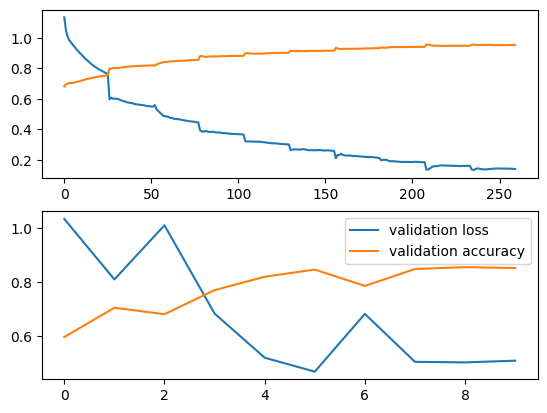

In [43]:
fig = plt.figure(num = 2)
fig1 = fig.add_subplot(2,1,1)
fig2 = fig.add_subplot(2,1,2)
fig1.plot(total_loss_train, label = 'training loss')
fig1.plot(total_acc_train, label = 'training accuracy')
fig2.plot(total_loss_val, label = 'validation loss')
fig2.plot(total_acc_val, label = 'validation accuracy')
plt.legend()
plt.show()

In [44]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [45]:
model.eval()
y_label = []
y_predict = []
with torch.no_grad():
    for i, data in enumerate(val_loader):
        images, labels = data
        N = images.size(0)
        images = Variable(images).to(device)
        outputs = model(images)
        prediction = outputs.max(1, keepdim=True)[1]
        y_label.extend(labels.cpu().numpy())
        y_predict.extend(np.squeeze(prediction.cpu().numpy().T))

# compute the confusion matrix
confusion_mtx = confusion_matrix(y_label, y_predict)
# plot the confusion matrix
plot_labels = ['akiec', 'bcc', 'bkl', 'df', 'nv', 'vasc','mel']
# plot_confusion_matrix(confusion_mtx, plot_labels)

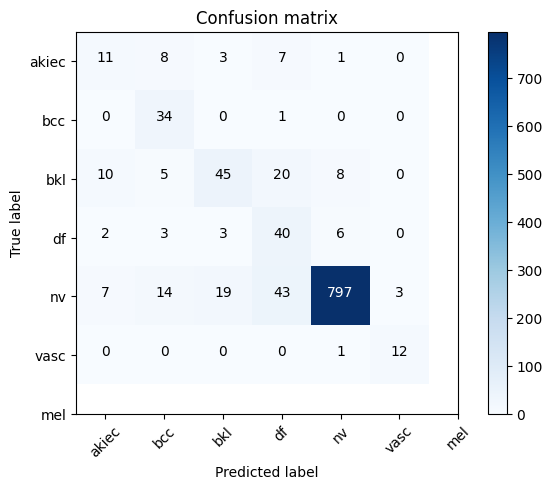

In [46]:
import itertools
plot_confusion_matrix(confusion_mtx, plot_labels)

In [47]:
# Generate a classification report
report = classification_report(y_label, y_predict, target_names=plot_labels)
print(report)

ValueError: Number of classes, 6, does not match size of target_names, 7. Try specifying the labels parameter

ValueError: shape mismatch: objects cannot be broadcast to a single shape.  Mismatch is between arg 0 with shape (7,) and arg 1 with shape (6,).

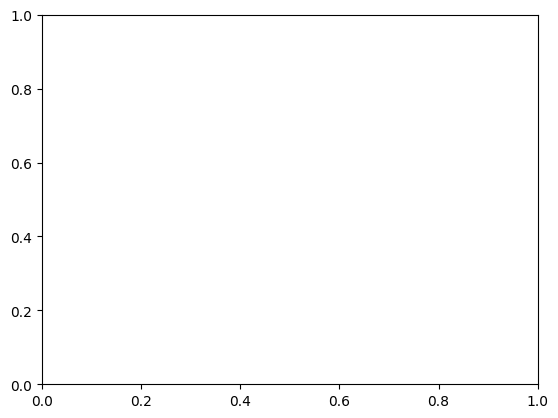

In [48]:
label_frac_error = 1 - np.diag(confusion_mtx) / np.sum(confusion_mtx, axis=1)
plt.bar(np.arange(7),label_frac_error)
plt.xlabel('True Label')
plt.ylabel('Fraction classified incorrectly')

In [49]:
# Assuming you already have your trained model
model.save("model.h5")


AttributeError: 'ResNet' object has no attribute 'save'

In [50]:
import torch

# Save the model's state_dict as a .pkl file
torch.save(model.state_dict(), "model.pkl")


In [51]:
dummy_input = torch.randn(1, 3, 224, 224)  # Adjust shape based on your model input
torch.onnx.export(model, dummy_input, "model.onnx")


RuntimeError: Input type (torch.FloatTensor) and weight type (torch.cuda.FloatTensor) should be the same or input should be a MKLDNN tensor and weight is a dense tensor

In [53]:
import torch

# Set model to evaluation mode
model.eval()

# Create a dummy input with the expected input shape
dummy_input = torch.randn(1, 3, 224, 224)

# Export the model to ONNX format
torch.onnx.export(
    model,
    dummy_input,
    "model.onnx",
    export_params=True,
    opset_version=11,           # Specify ONNX opset version; 11 is widely supported
    do_constant_folding=True,    # Optimizes model by folding constant nodes
    input_names=['input'],       # Name of the input layer
    output_names=['output'],     # Name of the output layer
    dynamic_axes={'input': {0: 'batch_size'}, 'output': {0: 'batch_size'}}  # Makes batch dimension dynamic
)


RuntimeError: Input type (torch.FloatTensor) and weight type (torch.cuda.FloatTensor) should be the same or input should be a MKLDNN tensor and weight is a dense tensor